In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import strax
# ADC->PE conversions for XENON1T
to_pe = 1e-3 * np.array([7.05, 0.0, 0.0, 8.09, 4.38, 7.87, 3.58, 7.5, 7.44, 4.82, 7.07, 5.79,  0.0, 5.55, 7.95, 7.02, 6.39, 8.1, 7.15, 7.43, 7.15, 11.4, 3.97, 7.28,  5.41, 7.4, 0.0, 0.0, 7.04, 7.27, 4.22, 16.79, 4.14, 7.04, 0.0, 5.38,  7.39, 7.02, 4.53, 5.17, 7.13, 5.48, 4.6, 7.33, 6.14, 6.52, 7.59,  4.76, 7.56, 7.54, 4.57, 4.6, 7.12, 8.0, 4.7, 8.68, 3.74, 4.97, 10.36,  7.53, 6.02, 12.45, 0.0, 4.49, 4.82, 0.0, 8.13, 7.27, 3.55, 5.65,  4.55, 8.64, 7.97, 0.0, 3.57, 3.69, 5.87, 5.12, 9.8, 0.0, 5.08, 4.09,  3.87, 8.17, 6.73, 9.03, 0.0, 6.93, 0.0, 6.52, 7.39, 0.0, 4.92, 7.48,  5.82, 4.05, 3.9, 5.77, 8.14, 7.62, 7.61, 5.55, 0.0, 7.12, 5.02, 4.57,  4.46, 7.44, 3.57, 7.58, 7.16, 7.33, 7.69, 6.03, 5.87, 9.64, 4.68,  7.88, 0.0, 10.84, 7.0, 3.62, 7.5, 7.45, 7.69, 7.69, 3.49, 3.61, 7.44,  6.38, 0.0, 5.1, 3.72, 5.22, 0.0, 0.0, 4.43, 0.0, 3.87, 0.0, 3.6,  5.35, 8.4, 5.1, 6.45, 5.07, 4.28, 3.5, 0.0, 7.28, 0.0, 4.25, 0.0,  4.72, 6.26, 7.28, 5.34, 7.55, 3.85, 5.54, 7.5, 7.31, 0.0, 7.76, 7.57,  6.66, 7.29, 0.0, 7.59, 3.8, 3.58, 5.21, 4.29, 7.36, 7.76, 4.0, 6.23,  5.86, 0.0, 7.34, 3.58, 3.57, 5.26, 0.0, 7.67, 4.05, 4.3, 4.21, 7.59,  7.59, 0.0, 6.41, 4.86, 3.73, 5.09, 7.59, 7.64, 7.7, 0.0, 5.25, 8.0,  5.32, 7.91, 0.0, 4.41, 11.82, 0.0, 4.51, 7.05, 8.63, 5.12, 4.45,  4.03, 0.0, 0.0, 3.54, 4.18, 9.5, 3.64, 3.67, 7.28, 3.59, 5.03, 3.6,  5.4, 7.18, 3.73, 6.21, 6.47, 3.7, 7.69, 4.58, 7.46, 6.74, 0.0, 3.66,  7.49, 7.55, 3.64, 0.0, 7.34, 4.06, 3.74, 3.97, 0.0, 4.29, 4.96, 3.77,  8.57, 8.57, 8.57, 8.57, 8.57, 8.57, 214.29, 171.43, 171.43, 171.43,  171.43, 171.43])

In [2]:
source_fn = 'test_records_uncomp'
# Measured with pax a few weeks ago, probably on laptop?
zlib_pickles_reduction = (684e6 * 0.183) /300e6 
zlib_pickles_time = 121 * 0.183

# Make data at various reduction levels

No reduction

In [3]:
records_raw = strax.load(source_fn)
orig_size_MB = records_raw.nbytes/1e6

Baselines at start and end of pulse cut

In [4]:
r = strax.load(source_fn)
r = strax.sort_by_time(r)
strax.baseline(r)
strax.cut_baseline(r)
records_cut_bl = r.copy()

Keep only waveforms of hits

In [5]:
r = strax.load(source_fn)
r = strax.sort_by_time(r)
strax.baseline(r)
strax.integrate(r)
hits = strax.find_hits(r)
strax.cut_outside_hits(r, hits)
records_cut_hits = r.copy()

As above, and 10 ms (but stupid) single electron tail cut

In [6]:
r = strax.load(source_fn)
r = strax.sort_by_time(r)
strax.baseline(r)
strax.integrate(r)
r = strax.exclude_tails(r, to_pe)
hits = strax.find_hits(r)
strax.cut_outside_hits(r, hits)
records_cut_tails = r.copy()

In [7]:
data = dict(raw=records_raw,
            baseline_cut=records_cut_bl,
            hits_only=records_cut_hits,
            tail_cut=records_cut_tails)

## Benchmark compressions

In [10]:
from time import time
import os
from functools import partial

# Add suboptimal compressors, to really show they are suboptimal
import snappy
import zlib
strax.io.COMPRESSORS.update(dict(
    # zlib 4 matches level used in eventbuiler
    zlib=dict(compress=partial(zlib.compress, level=4), decompress=zlib.decompress),
    snappy=dict(compress=partial(snappy.compress), decompress=snappy.decompress),
))

results = []

# TODO n_trials
for condition, d in data.items():
    print("\n", condition)

    for compressor in ['none'] + list(strax.io.COMPRESSORS.keys()):
        print(compressor)
        fn = f'test_{compressor}'
        t0 = time()
        strax.save(fn, d, compressor=compressor)
        t1 = time()
        strax.load(fn)
        t2 = time()

        r = dict(compressor=compressor, condition=condition)
        r['save_speed'] = orig_size_MB / (t1 - t0)
        r['load_speed'] = orig_size_MB / (t2 - t1)
        new_size = os.path.getsize(strax.io._fn(fn, compressor)) / 1e6
        r['size_ratio'] =  new_size  / orig_size_MB
        results.append(r)
        
        strax.delete(fn)
        
results = pd.DataFrame(results)


 raw
none
bz2
zstd
blosc
zlib
snappy

 baseline_cut
none
bz2
zstd
blosc
zlib
snappy

 hits_only
none
bz2
zstd
blosc
zlib
snappy

 tail_cut
none
bz2
zstd
blosc
zlib
snappy


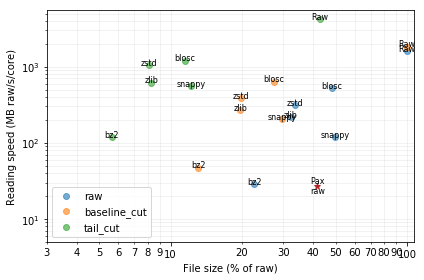

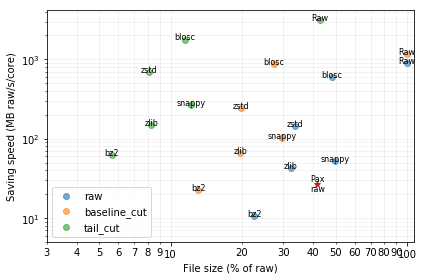

In [11]:
ann_font = dict(fontsize=8, horizontalalignment='center')

for save in False, True:
    for condition in data.keys():
        if condition == 'hits_only':
            continue
        d = results[results['condition'] == condition]
        x = 100 * d['size_ratio'].values
        y = d['save_speed' if save else 'load_speed'].values
        plt.scatter(x, y, label=condition, alpha=0.6)
        for i, (_, q) in enumerate(d.iterrows()):
            label = dict(none='Raw').get(q['compressor'], q['compressor'])
            plt.annotate(label, (x[i], y[i]),
                         **ann_font)

    pax = (100 * zlib_pickles_reduction, 300/zlib_pickles_time*2)    # *2 since save + load
    plt.scatter([pax[0]], pax[1], marker='*', c='firebrick')
    plt.annotate('Pax\nraw', pax, verticalalignment='center', **ann_font)

    plt.ylabel(("Saving" if save else "Reading") + " speed (MB raw/s/core)")
    plt.xlabel("File size (% of raw)")
    plt.yscale('log')
    plt.ylim(5, None)
    plt.grid(alpha=0.2, which='both')

    plt.xscale('log')
    plt.legend(loc='lower left')
    plt.xlim(3, 107)

    ax = plt.gca()
    for axis in [ax.xaxis]:    
        axis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
        axis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

    plt.tight_layout()
    plt.savefig('compress_benchmark_%s.pdf' % ('save' if save else 'load'))
    plt.show()